# About run_sequence_analysis

This notebook creates dividies students into groups, loads their action sequences and runs the infogain analysis

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
%aimport utils_read_parsing
%aimport generalized_seq_miner
from utils_timeline_viz import *
from utils_read_parsing import *
from generalized_seq_miner import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 12,4
from matplotlib.backends.backend_pdf import PdfPages
import os
import numpy as np
import pandas as pd
import getpass
import datetime
import json
import matplotlib
import matplotlib.pyplot as plt
from itertools import groupby
from tabulate import tabulate
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)
# FOLDER =  'C:\\Users\\'+getpass.getuser()+'\\Documents\\Personal Content\\Lab_skills_study\\parsed log data'

# Loading data

We grab the student learning data

In [2]:
df_all = get_df_all_factors(all_vars=True)
variables = list(set(df_all['variable']))
ids = list(set(df_all['sid']))
N = len(ids)
print 'We have',N,'students.'
print 'Running the analaysis on the following variables:',', '.join(variables)

We have 147 students.
Running the analaysis on the following variables: Battery voltage, Area, Width, Separation, Wavelength, Concentration


We grab the sequences

In [3]:
import pickle
pickle_in_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_seqs.txt'),"r")
pickle_in_blocked_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_blocked_seqs.txt'),"r")
pickle_in_all_blocked_timecoords = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_blocked_timecoords.txt'),"r")
all_seqs = pickle.load(pickle_in_seqs)
all_blocked_seqs = pickle.load(pickle_in_blocked_seqs)
all_blocked_timecoords = pickle.load(pickle_in_all_blocked_timecoords)
pickle_in_seqs.close()
pickle_in_blocked_seqs.close()
pickle_in_all_blocked_timecoords.close()

# Splitting students

## Count number of "exact" main scores in each activity (1 and 2)

In [4]:
df_all.head(6)

,sid,sim,variable,pre,main,cvs_graph,cvs_table,cvs_table_only,cvs_graph_inverse,cvs_graph_axes,qual_score,quant_score,activity_order,sim_index,similar_sim,lab_experience,lab_experience_chem,lab_experience_phys,prior_number_virtual_labs,overall POCC,PC1,PC2,pre_with_ident,main_with_ident,CVS_context,use_table,use_graph,use_concentration,use_width,use_area,use_separation,use_all_vars,use_graph_beers,use_table_beers,use_table_capacitor,use_graph_capacitor
0,10127163,L,Concentration,0.0,2.0,1.0,1.0,0.0,0,1.0,1.0,1.0,LC,1,0,1.0,1.0,1.0,1,17,-0.62,0.63,1.0,3.0,2.0,1,1,1,1,1,1,4,1,1,1,1
1,10127163,L,Wavelength,0.0,0.0,1.0,1.0,0.0,0,1.0,1.0,NaN,LC,1,0,1.0,1.0,1.0,1,17,-0.62,0.63,1.0,1.0,2.0,1,1,1,1,1,1,4,1,1,1,1
2,10127163,L,Width,0.0,2.0,1.0,1.0,0.0,0,1.0,1.0,1.0,LC,1,0,1.0,1.0,1.0,1,17,-0.62,0.63,1.0,3.0,2.0,1,1,1,1,1,1,4,1,1,1,1
3,10127163,C,Area,2.0,2.0,1.0,1.0,0.0,0,1.0,1.0,1.0,LC,2,0,1.0,1.0,1.0,1,17,-0.62,0.63,3.0,3.0,2.0,1,1,1,1,1,1,4,1,1,1,1
4,10127163,C,Separation,2.0,2.0,1.0,1.0,0.0,1,2.0,1.0,1.0,LC,2,0,1.0,1.0,1.0,1,17,-0.62,0.63,3.0,3.0,2.0,1,1,1,1,1,1,4,1,1,1,1
5,10127163,C,Battery voltage,2.0,2.0,0.0,1.0,1.0,0,0.0,NaN,NaN,LC,2,0,1.0,1.0,1.0,1,17,-0.62,0.63,3.0,3.0,1.0,1,1,1,1,1,1,4,1,1,1,1


In [5]:
def count_exact(scores):
    return int(sum([s==2.0 for s in scores]))

In [6]:
scores = pd.pivot_table(df_all, values=['pre','main'], index=['sid','sim_index'], aggfunc=count_exact)
scores.reset_index().set_index('sid',inplace=True)
scores.head()

main  pre
sid      sim_index           
10127163 1           2.0  0.0
         2           3.0  3.0
10192168 1           0.0  0.0
         2           1.0  0.0
10232160 1           0.0  0.0

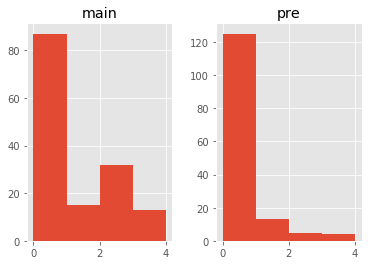

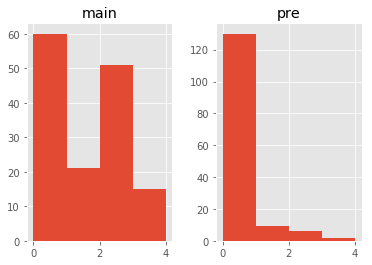

In [7]:
scores.groupby('sim_index').hist(bins=range(5));

## What if we split by increase or decrease in number of exact scores from pre to main?

In [8]:
def make_group(row):
    if row['pre'] < row['main']:
        return 'LH'
    else:
        return 'LL'
    
scores['group'] = scores.apply(make_group,axis=1)

In [9]:
scores.groupby(['sim_index','group']).describe()

main                                        pre              \
                count  mean   std  min  25%  50%  75%  max count  mean   std   
sim_index group                                                                
1         LH     48.0  2.00  0.65  1.0  2.0  2.0  2.0  3.0  48.0  0.10  0.37   
          LL     99.0  0.22  0.66  0.0  0.0  0.0  0.0  3.0  99.0  0.30  0.73   
2         LH     82.0  1.93  0.64  1.0  2.0  2.0  2.0  3.0  82.0  0.17  0.47   
          LL     65.0  0.15  0.57  0.0  0.0  0.0  0.0  3.0  65.0  0.20  0.67   

                                          
                 min  25%  50%  75%  max  
sim_index group                           
1         LH     0.0  0.0  0.0  0.0  2.0  
          LL     0.0  0.0  0.0  0.0  3.0  
2         LH     0.0  0.0  0.0  0.0  2.0  
          LL     0.0  0.0  0.0  0.0  3.0

How many students have a high number of exact scores in pre and main? Should we exclude those? Or change their labels?

In [10]:
scores[(scores['pre']==3)&(scores['main']==3)].shape[0],scores[(scores['pre']==2)&(scores['main']==2)].shape[0]

(4, 5)

There are 4 and 5 students that have 3 exact and 2 exact scores, respectively, in both pre and main and are thus labelled LL.

### How to people transition from one group to another from activity 1 to 2?

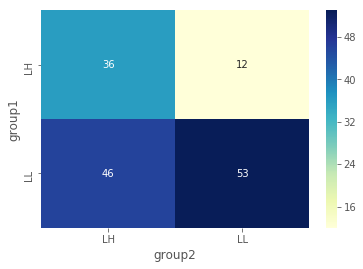

In [11]:
df_all = df_all.merge(scores[['group']], how='outer', on=['sid','sim_index']);
combogroups = df_all[df_all['sim_index']==1][['sid','group']].rename(columns={'group':'group1'}).merge(df_all[df_all['sim_index']==2][['sid','group']].rename(columns={'group':'group2'}), how='outer', on=['sid']);
combogroups.drop_duplicates(inplace=True)
sns.heatmap(pd.pivot_table(combogroups, index='group1',columns='group2',values='sid',aggfunc=len),cmap="YlGnBu",annot=True)#.fillna(0))

The bulk of students go from LL to LH or remain in their original group.

## What if we split by those who had at least one instance of pre=2

In [12]:
# def make_group(row):
#     if row['pre']>0:
#         if row['main']>0:
#             return 'HH'
#         else:
#             return 'HL'
#     else:
#         if row['main']>0:
#             return 'LH'
#         else:
#             return 'LL'
    
# scores['group'] = scores.apply(make_group,axis=1)

In [13]:
# scores.groupby(['sim_index','group']).describe()

There are many more LH than LL in activity 2, the opposite in activity 1.
The number of H_ remains the same.

### How to people transition from one group to another from activity 1 to 2?

In [14]:
# df_all = df_all.merge(scores[['group']], how='outer', on=['sid','sim_index']);
# combogroups = df_all[df_all['sim_index']==1][['sid','group']].rename(columns={'group':'group1'}).merge(df_all[df_all['sim_index']==2][['sid','group']].rename(columns={'group':'group2'}), how='outer', on=['sid']);
# combogroups.drop_duplicates(inplace=True)
# sns.heatmap(pd.pivot_table(combogroups, index='group1',columns='group2',values='sid',aggfunc=len),cmap="YlGnBu",annot=True)#.fillna(0))

**grey boxes have 0 students**

* Most LL students remain LL (48) and never model an exact relationship
* Many LL become LH (29)
* Many HH students remain high learning despite lower pres in 2nd activity (10)

## What if we split by learning gains from activity 1

We use the following formula for learning gains:

$gain = \frac{main-pre}{max\_score-pre}$

where max_score is the number of variables

In [15]:
max_score = len(variables)
scores['gains'] = (scores['main']-scores['pre'])/(max_score - scores['pre'])
t = scores['gains'].value_counts().sort_index()
t

-0.50      1
-0.33      2
-0.25      1
-0.20      6
 0.00    154
 0.17     30
 0.20      7
 0.25      4
 0.33     69
 0.40      4
 0.50     16
Name: gains, dtype: int64

* LL 97 students had null or negative learning gains
* LH 58 students had learning gain

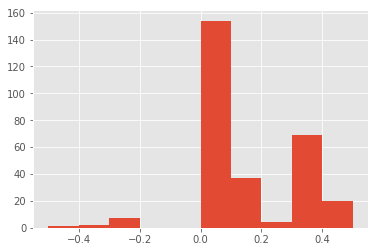

In [16]:
scores['gains'].hist()

# Running analysis

## Setting up the data

We limit it to the first activity

In [17]:
df_all = df_all[df_all['sim_index']==1]

In [18]:
len(df_all['sid'].unique())

147

In [19]:
def get_levels_and_students_per_attribute(df, attribute):
    d={}
    levels = list(df[attribute].unique())
    for level in levels:
        d[level] = list(df[df[attribute]==level]['sid'].unique())
    return levels,d
    
# levels, students_by_attribute = get_levels_and_students_per_attribute(df_all[df_all['variable']=='Concentration'], 'group')
levels, students_by_attribute = get_levels_and_students_per_attribute(df_all, 'group')
for level in levels:
    print level, len(students_by_attribute[level])
# students_by_attribute.pop('HL', None)
# levels.remove('HL')

LH 48
LL 99


In [20]:
attribute = 'group'
level1 = 'LL'
level2 = 'LH'
action_seqs = all_blocked_seqs['beers']
time_coords = all_blocked_timecoords['beers']

## Setting parameters

In [21]:
#We split activities into 3 time bins
num_bins = 3
#Sequences of action of interest can be a minimum and max length
shortest_seq_length = 2
longest_seq_length = 15
# for mining sequences in large groups, we want to make sure we find interesting sequences that have been done by a minimum number of people.
# Thus we use a cut off of 0.3-0.5 to only analyze sequences done by at least 30-50% of students within a group.
# Thus the groups can have slightly different sizes.
cut_off = 0.2

## Running the sequence mining

In [22]:
%aimport generalized_seq_miner
freqs = get_frequencies_by_bin(action_seqs,time_coords, num_bins, shortest=shortest_seq_length, longest=longest_seq_length)

In [23]:
freqs[10127163][0].most_common(5)

[('V_wavelength,V_width', 3),
 ('V_width,V_wavelength', 3),
 ('V_concentration,V_wavelength,P', 2),
 ('V_wavelength,V_width,V_concentration', 2),
 ('V_concentration,V_wavelength', 2)]

In [24]:
# The code below finds, for each sequence, the number of students in each group that used that sequence at least once in that time bin
# For instance, for the sequence 'BCB': array([[ .2,  1.],[ 1.,  0.]]), it was used at least once by 2 of the students in the "passed" group in the first half of their activity.
seq_use = get_sequence_use_by_timebin(action_seqs, time_coords, students_by_attribute, num_bins, attribute,
            levels, shortest_seq_length, longest_seq_length, cut_off)

In [27]:
## Now we can calculate the information gain of this sequence over groups in time. In other words, high information gain sequences
# are used differently over time by groups while low information gain sequences are used closer to randomly by groups over time.
tops = rank_sequences(seq_use,num_bins)[-20:]
tops.sort(key=lambda tup: tup[1],reverse=True)
for s,f in tops:
    print round(f,3),'\t',s

0.773 	V_other,V_width,P
0.61 	T_add,G_add,G_axis_trialnumber
0.606 	G_add,G_axis_trialnumber
0.549 	V_wavelength,P,V_wavelength,P
0.541 	P,V_wavelength,P,V_wavelength,P
0.518 	T_add,G_add,G_axis_concentration
0.492 	V_other,V_wavelength,P
0.465 	V_other,V_wavelength,V_width
0.45 	P,V_concentration,P,V_wavelength
0.439 	G_scale_log,G_scale_inverse,G_scale_linear
0.436 	V_wavelength,V_width,P
0.428 	V_wavelength,P,V_concentration
0.414 	T_add,V_width,T_add,V_width,T_add,V_width,T_add,V_width,T_add,V_width,T_add,G_add
0.405 	V_width,T_add,V_width,T_add,V_width,T_add,V_width,T_add,V_width,T_add,V_width,T_add,G_add
0.397 	V_other,V_width
0.388 	V_concentration,V_wavelength,V_concentration
0.383 	T_add,V_wavelength,T_add,V_wavelength,T_add,V_wavelength,T_add,P
0.378 	V_other,V_concentration
0.366 	V_wavelength,V_concentration,V_wavelength
0.366 	V_concentration,V_wavelength,P


## Make viz

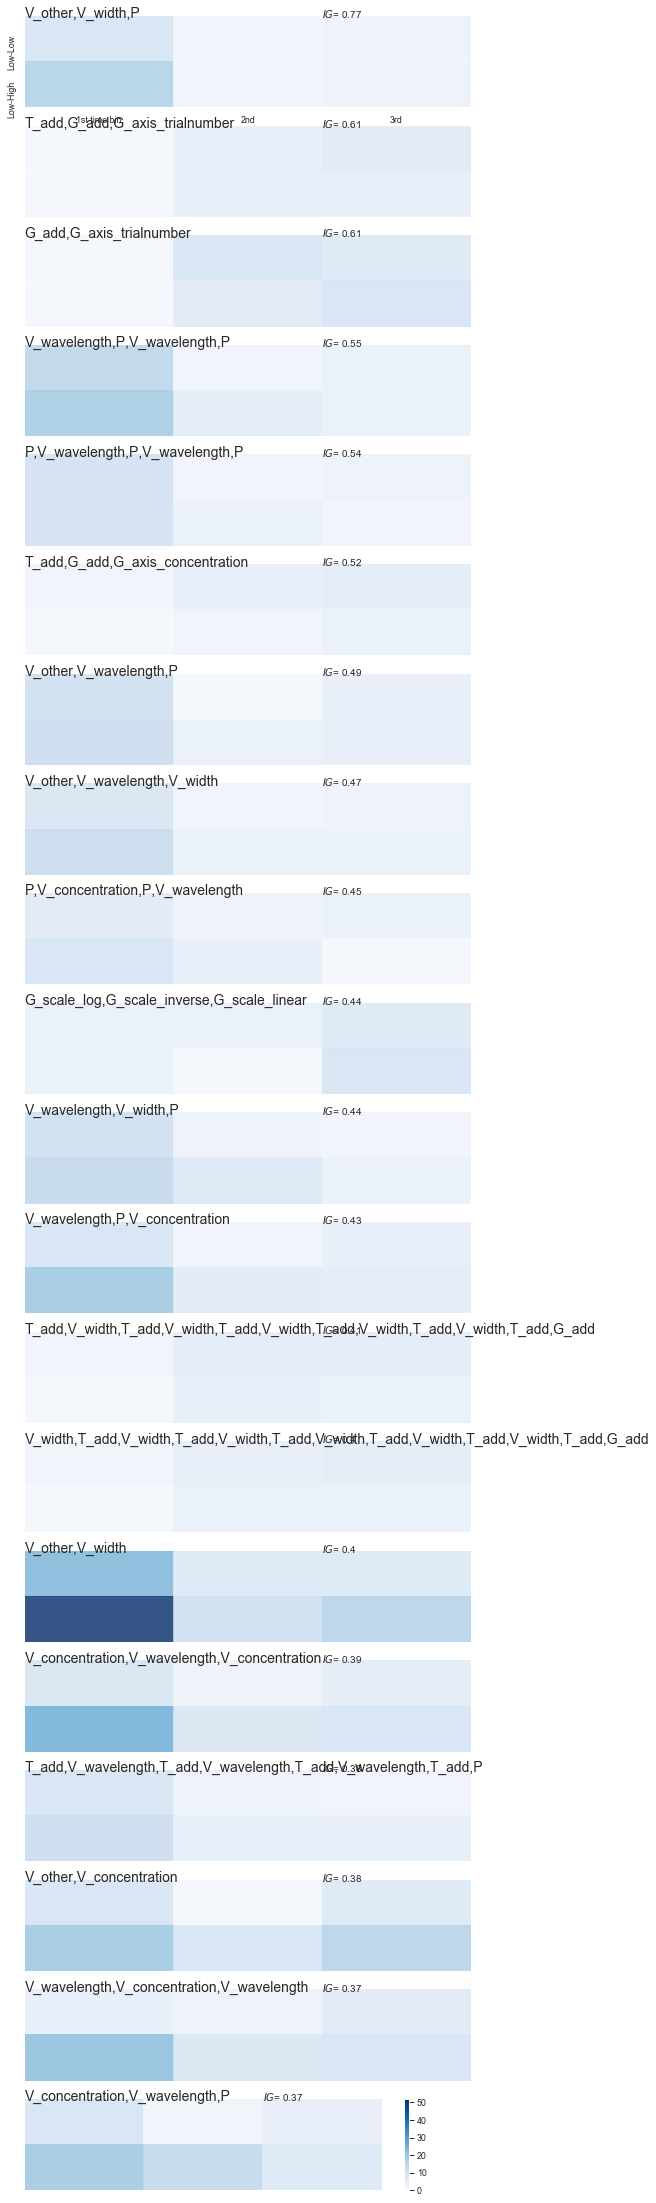

In [42]:
sns.set_style("darkgrid")
sns.set_context("paper")
seqs_plot = zip(*tops)[0]
fig, axes = plt.subplots(len(seqs_plot),1,figsize=(8,40))#, sharex=True, sharey=True)
maximum = int(max([np.amax(counts) for seq,counts in seq_use.iteritems() if seq in seqs_plot]))
for i,(seq,ig) in enumerate(tops):
    ax = axes[i]
    data = seq_use[seq]
    ax.text(0,0.05, seq, fontsize=14)
    ax.text(2.0,0.05, "$IG$= {0}".format(str(round(ig,2))), fontsize=10)

    # heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.8, vmin=0)
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=False) #, annot_kws={'fontweight':'bold'})

    if i==0:
        xlabels = map(str, np.arange(data.shape[1])+1) 
        xlabels = ['1st time bin','2nd','3rd']
        ax.set_xticklabels([],)
        ax.set_xticks(np.arange(data.shape[1]) + 0.5)
        ax.set_xticklabels(xlabels)
        ax.set_yticks(np.arange(data.shape[0]) + 0.5)
        ylabels = ['Low-Low','Low-High']
        ax.set_yticklabels(ylabels)

        cbar = ax.figure.colorbar(ax.collections[0])
#         cbar.set_ticks([0,1,3,5,7,9,11,13])
#         cbar.set_ticklabels([0,1,3,5,7,9,11,13])
    else: 
        ax.set_xticklabels(['','','',''])
        ax.set_yticklabels(['',''])

        

#     cbar = ax.figure.colorbar(ax.collections[0])
#     cbar.set_ticks([0,1,3,5,7,9,11,13])
#     cbar.set_ticklabels([0,1,3,5,7,9,11,13])

#     fig.set_size_inches(4,1.6*len(all_seqs))
#     ax.set_frame_on(False)
#     ax.tick_params(
#         axis='both',        # changes apply to both the x and y-axis
#         which='both',       # both major and minor ticks are affected
#         bottom='off',       # ticks along the those edges are off
#         right='off', 
#         left='off',
#         top='off') 
# fig.savefig('heatmap_all.svg')

# Todo

* make viz
* look into capacitance problem
